In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import time
import pandas as pd
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import seaborn as sns
from sklearn.decomposition import PCA
from make_models import get_MRI_CVAE_3D
from tqdm import tqdm
import tensorflow as tf
from rsa_funcs import fit_rsa,make_RDM,get_triu

/data/bergerar/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
pwd

'/mmfs1/data/bergerar/BC-MRI-ADHD/Code'

In [3]:
#load data
stuff = np.load('../Assets/brain_array-440.npz')
print(list(stuff.keys()))

data = stuff['data']
control = stuff['controls']
patients = stuff['patients']
n = data.shape[0]
#print(data.shape)
#data[patients,:,:,:].shape
#data[patients].shape

data_patients = data[patients,:,:,:]
data_controls = data[control,:,:,:]

print(data_patients.shape)
print(data_controls.shape)

['data', 'controls', 'patients']
(179, 64, 64, 64)
(261, 64, 64, 64)


In [4]:
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CVAE_3D(input_shape=(64,64,64,1),
                    latent_dim=2,
                    beta=1,
                    disentangle=False,
                    gamma=1,
                    bias=True,
                    batch_size = 64,
                    kernel_size = 3,
                    filters = 32,
                    intermediate_dim = 128,
                    opt=None)

In [5]:
cvae.load_weights('../Assets/tf_weights_10000_AB/tf_weightsAB')

In [6]:
data_patients.shape

(179, 64, 64, 64)

In [7]:
def get_reconstruction(data_in,adhd = True):

    z = z_encoder.predict(data_in)[0] # mu,std,sample
    s = s_encoder.predict(data_in)[0]

    if adhd==True:
        l = np.hstack((z,s))
    else:
        l = np.hstack((z,np.zeros(s.shape)))

    recon = cvae_decoder(l)[:,:,:,:,0]
    return recon

In [8]:
%%time
recon_patients = get_reconstruction(data_patients,adhd = True)
recon_controls = get_reconstruction(data_controls,adhd = False)


CPU times: user 1min 36s, sys: 12.7 s, total: 1min 49s
Wall time: 36.2 s


In [9]:
recon_patients.shape

TensorShape([179, 64, 64, 64])

In [10]:
np.array(recon_patients).max()

0.8697046

In [11]:
np.array(recon_patients).min()

0.008435845

In [12]:
np.array(data_patients).max()


1.0

In [13]:
np.array(data_patients).min()


0.0

In [14]:
# reconstructions = cvae_decoder.predict(np.hstack((background_features_adhd, salient_features_adhd)))

In [15]:
# reconstructions = reconstructions[:,:,:,:,0]

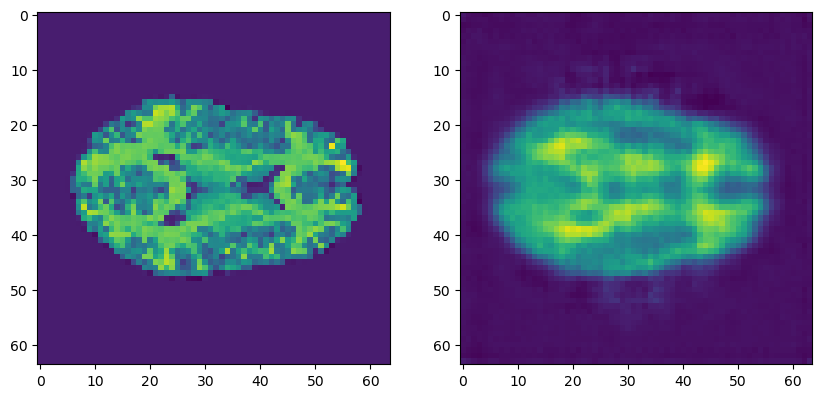

In [16]:
#subject 0
s = 0
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

In [17]:
# MSE subject 0
data = data_patients[0,:,:,:]
predict = recon_patients[0,:,:,:]
# Using 'auto'/'sum_over_batch_size' reduction type.
mse = tf.keras.losses.MeanSquaredError()
mse(data, predict).numpy()

0.001449396

In [18]:
# MSE subject 0
data = np.array(data_patients[0,:,:,:])
predict = np.array(recon_patients[0,:,:,:])
mse = ((data-predict)**2).mean()

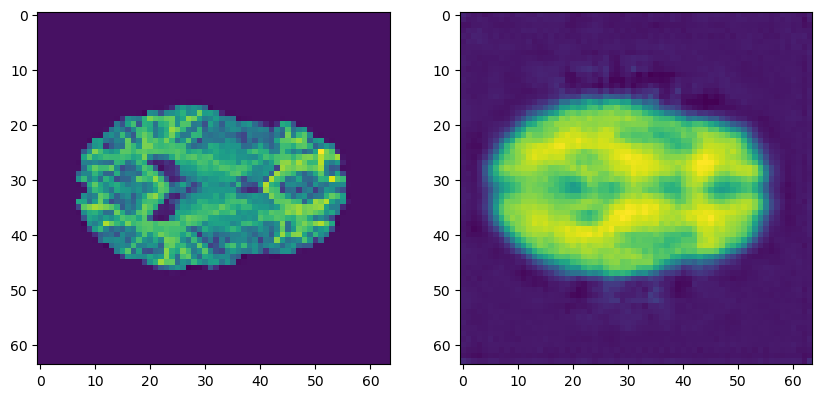

In [19]:
#subject 1
s = 1
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

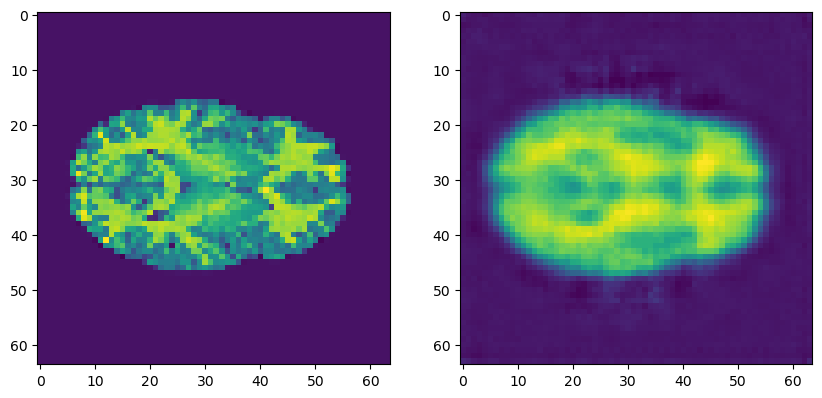

In [20]:
#subject 2
s = 2
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

In [21]:
# MSE loop
mse_list = []
for s in range(0,179):
    data = np.array(data_patients[s,:,:,:])
    predict = np.array(recon_patients[s,:,:,:])
    mse = ((data-predict)**2).mean()
    mse_list.append(mse)

mse_arr = np.array(mse_list)

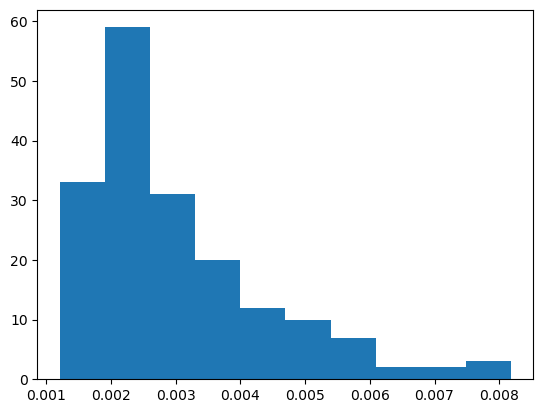

In [22]:
plt.hist(mse_arr)
plt.show()

In [23]:
np.argmin(mse_arr) #

5

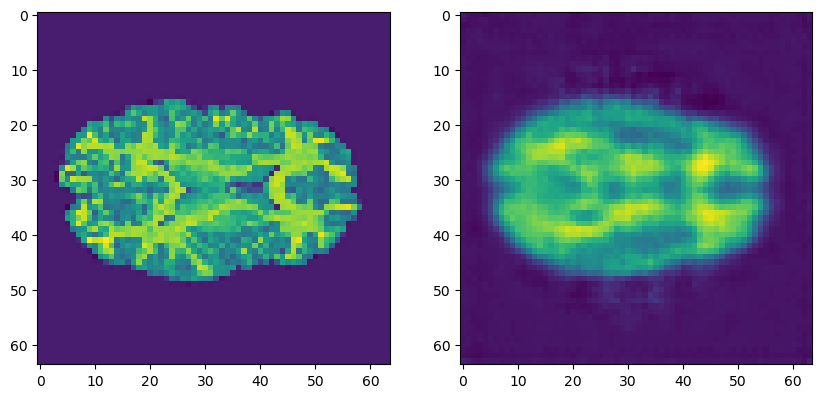

In [24]:
# best reconstruction
s = 5
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

In [25]:
np.argmax(mse_arr) #

154

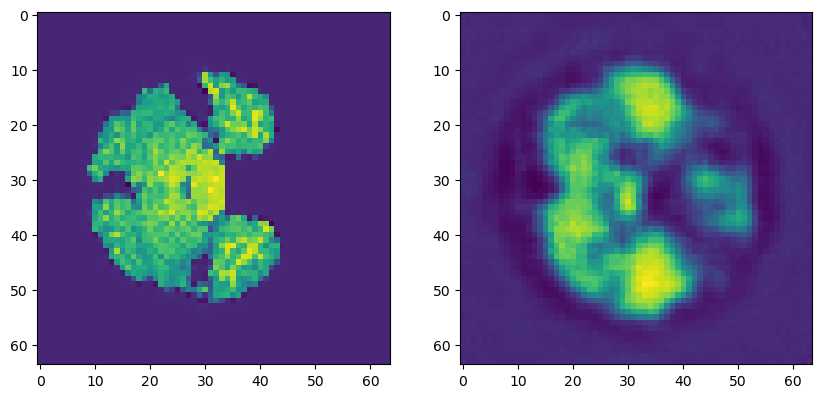

In [26]:
# worst reconstruction
s = 154
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

In [99]:
df = pd.read_csv('../Data/df_440.csv')

In [128]:
ADHDdf = df[df['DX'] != 0]
TDdf = df[df['DX'] == 0]
ADHD_index_df = ADHDdf[ADHDdf['ADHD Index']!= -999]

In [135]:
ADHDdf.to_csv('../Data/ADHDdf_179.csv')

In [ ]:
# 90, 93, 178

In [94]:
ADHD_bad = ADHDdf[ADHDdf['ADHD Index'] == -999]

In [95]:
ADHD_bad

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Subject,ScanDir ID,Site,Gender,Age,Handedness,DX,...,Med Status,QC_Rest_1,QC_Rest_2,QC_Rest_3,QC_Rest_4,QC_Anatomical_1,QC_Anatomical_2,ID,subID,has_brain
198,225,225,225,225,10044.0,5,NaN,9.81,0.33,1,...,2.0,0.0,1.0,NaN,NaN,1.0,NaN,NaN,sub-0010044,True
203,230,230,230,230,10056.0,5,1.0,15.63,0.64,3,...,2.0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,sub-0010056,True
386,581,581,581,581,2897046.0,1,0.0,9.17,1.00,3,...,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,sub-2897046,True


In [130]:
symptom_series = ADHD_index_df['ADHD Index']

In [131]:
symptom_df = symptom_series.to_frame()

In [132]:
symptom_df.shape

(179, 1)

In [133]:
s_patients = s_encoder.predict(data_patients)[0]
z_patients = z_encoder.predict(data_patients)[0]
symptom = np.array(symptom_df)

# latent_shared_z = z_encoder.predict(data_patients)[0]
# latent_shared
# latent_specific = s_encoder.predict(data_patients)[0]

In [107]:
symptom.shape

(176, 1)

In [87]:
s_patients.shape

(179, 2)

In [83]:
z_patients.shape

(179, 2)

In [84]:
symptom.shape

(176, 1)

In [108]:
s_patients_rdm = make_RDM(s_patients)
z_patients_rdm = make_RDM(z_patients)
symptom_rdm = make_RDM(symptom)

In [109]:
symptom_rdm.shape

(176, 176)

In [110]:
z_patients_rdm.shape

(179, 179)

In [ ]:
# Need to make them the same sized square since I took out -999 values ??

In [90]:
rsa_analysis = dict()
rsa_s = np.array([fit_rsa(s_patients, symptom_rdm)]).transpose()

AssertionError: not a square

In [51]:
fit_rsa(s_patients_rdm, z_patients_rdm)

0.35611473990968656

In [42]:
shared_similarity = make_RDM(latent_shared)
specific_similarity  = make_RDM(latent_specific)

In [43]:
data = [shared_similarity,specific_similarity]

rsa_analysis = dict()
rsa = np.array([fit_rsa(data_rdm, model_rdm)]).transpose()

NameError: name 'data_rdm' is not defined

In [74]:
fit_rsa??

Signature: fit_rsa(rdm_data, rdm_model)
Docstring: <no docstring>
Source:   
def fit_rsa(rdm_data,rdm_model):
    return np.corrcoef(get_triu(rdm_data),get_triu(rdm_model))[0,1]
File:      /mmfs1/data/bergerar/BC-MRI-ADHD/Code/<ipython-input-73-75a28e7ba928>
Type:      function


In [ ]:
fit_rsa

ValueError: A 2-dimensional array must be passed.

In [54]:
# latent vectors
bg_features_adhd = z_encoder.predict(data_patients)[0] # returns mean,std and sample of latent vectors, we take mean here
sl_features_adhd = s_encoder.predict(data_patients)[0]

In [55]:
# latent vectors
bg_features_td = z_encoder.predict(data_controls)[0] # returns mean,std and sample of latent vectors, we take mean here
sl_features_td = s_encoder.predict(data_controls)[0]

In [80]:
reconstructions = cvae_decoder.predict(np.hstack((bg_features_adhd,sl_features_adhd)))
reconstructions = reconstructions[:,:,:,:,0]

In [85]:
reconstructions.shape

(179, 64, 64, 64)

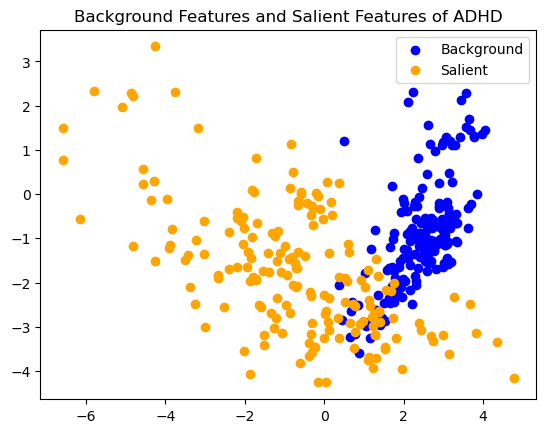

In [92]:
plt.scatter(bg_features_adhd[:,0],bg_features_adhd[:,1], label='Background', color = 'blue')
plt.scatter(sl_features_adhd[:,0],sl_features_adhd[:,1], label='Salient', color = 'orange')
plt.title('Background Features and Salient Features of ADHD')
plt.legend()
plt.show()
#what are these axes I cannot label them for the life of me but at least it looks cool
#I dont know what to title it but ... at least it looks cool

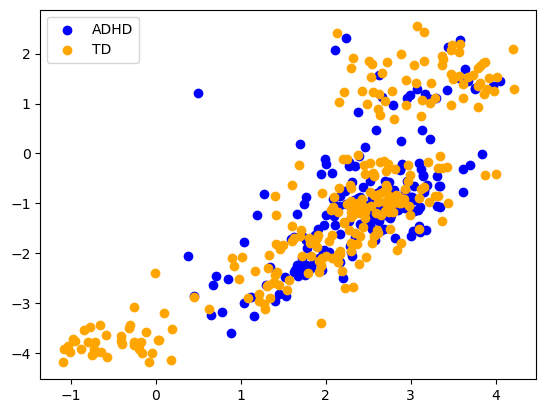

In [58]:
plt.scatter(bg_features_adhd[:,0],bg_features_adhd[:,1], label='ADHD', color = 'blue')
plt.scatter(bg_features_td[:,0],bg_features_td[:,1], label='TD', color = 'orange')
#plt.title('Background Features and Salient Features of ADHD')
plt.legend()
plt.show()
#what are these axes I cannot label them for the life of me but at least it looks cool
#I dont know what to title it but ... at least it looks cool

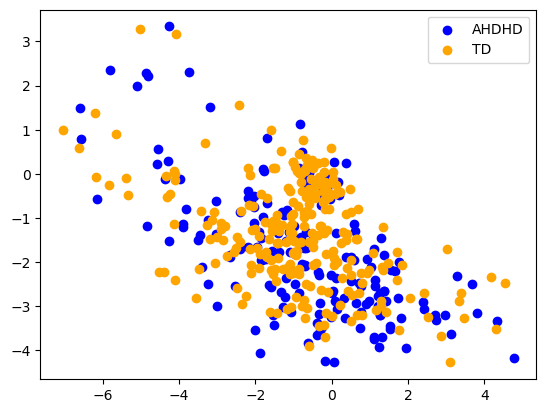

In [59]:
plt.scatter(sl_features_adhd[:,0],sl_features_adhd[:,1], label='AHDHD', color = 'blue')
plt.scatter(sl_features_td[:,0],sl_features_td[:,1], label='TD', color = 'orange')
#plt.title('Background Features and Salient Features of ADHD')
plt.legend()
plt.show()
#what are these axes I cannot label them for the life of me but at least it looks cool
#I dont know what to title it but ... at least it looks cool